In [49]:
import sys

assert sys.version_info >= (3, 7)

In [50]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd

housing_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/dubai_apt.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
import matplotlib.pyplot as plt
from pathlib import Path
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

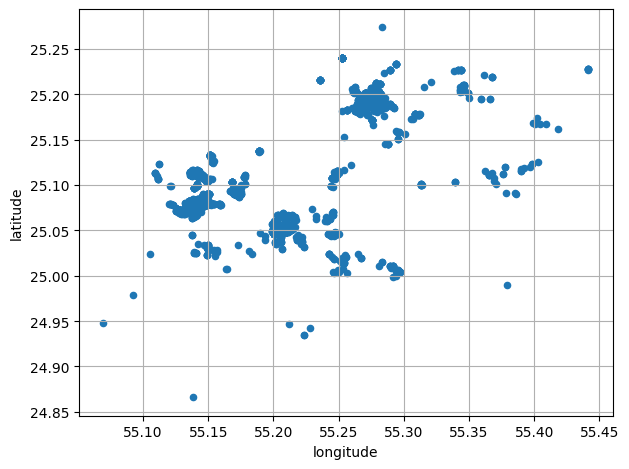

In [53]:
housing_data.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

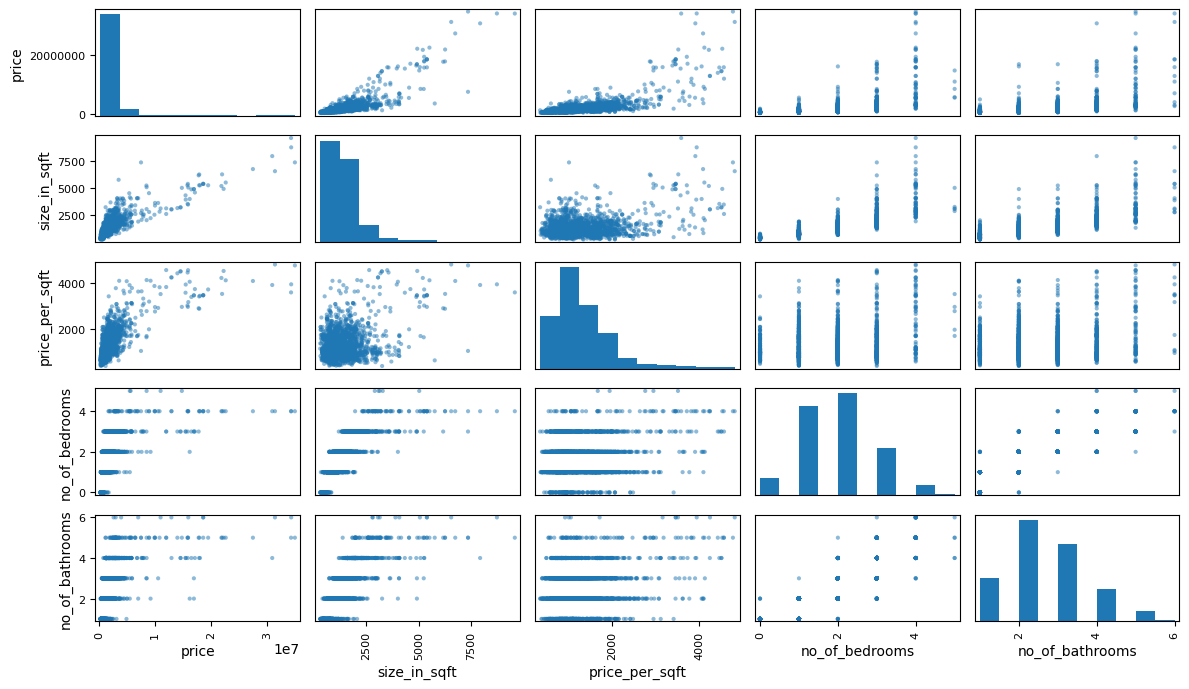

In [54]:
from pandas.plotting import scatter_matrix
attributes = ["price", "size_in_sqft", "price_per_sqft",
              "no_of_bedrooms","no_of_bathrooms"]
scatter_matrix(housing_data[attributes], figsize=(12, 7))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

In [55]:
housing_data["bathroom_to_bedroom"] = housing_data["no_of_bathrooms"] / housing_data["no_of_bedrooms"]
housing_data.describe()

,id,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,bathroom_to_bedroom
count,1.905000e+03,1905.000000,1905.000000,1.905000e+03,1905.000000,1905.000000,1905.000000,1905.000000,1905.0
mean,7.573308e+06,25.116538,55.212338,2.085830e+06,1417.050394,1327.243785,1.793176,2.512861,inf
std,1.925252e+05,0.062647,0.068794,2.913200e+06,891.487639,668.473559,0.949489,1.063117,NaN
min,5.528049e+06,24.865992,55.069311,2.200000e+05,294.000000,361.870000,0.000000,1.000000,0.5
25%,7.560167e+06,25.072791,55.145389,8.900000e+05,840.000000,870.920000,1.000000,2.000000,1.0
50%,7.631829e+06,25.096700,55.207506,1.400000e+06,1271.000000,1169.590000,2.000000,2.000000,1.5
75%,7.670328e+06,25.188130,55.271797,2.200000e+06,1703.000000,1622.500000,2.000000,3.000000,2.0
max,7.706643e+06,25.273623,55.441623,3.500000e+07,9576.000000,4805.870000,5.000000,6.000000,inf


In [56]:
corr_matrix = housing_data.corr()
corr_matrix["price"].sort_values(ascending=False)

<ipython-input-56-19f22c3c2881>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_data.corr()


price                  1.000000
size_in_sqft           0.808595
price_per_sqft         0.705538
no_of_bedrooms         0.514151
no_of_bathrooms        0.502263
private_pool           0.325857
latitude               0.206775
concierge              0.113217
maid_room              0.109675
private_gym            0.089794
view_of_water          0.088400
private_jacuzzi        0.073879
private_garden         0.049032
unfurnished            0.029904
built_in_wardrobes     0.026963
maid_service           0.019678
central_ac             0.016365
view_of_landmark       0.015263
covered_parking        0.011251
balcony                0.006558
walk_in_closet        -0.003760
shared_spa            -0.003985
longitude             -0.015395
kitchen_appliances    -0.021120
study                 -0.023678
id                    -0.035908
shared_gym            -0.058010
barbecue_area         -0.079268
shared_pool           -0.084076
vastu_compliant       -0.084158
security              -0.085007
networke

In [57]:

housing = housing_data.drop(['price_per_sqft','bathroom_to_bedroom'], axis=1)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905 entries, 0 to 1904
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1905 non-null   int64  
 1   neighborhood         1905 non-null   object 
 2   latitude             1905 non-null   float64
 3   longitude            1905 non-null   float64
 4   price                1905 non-null   int64  
 5   size_in_sqft         1905 non-null   int64  
 6   no_of_bedrooms       1905 non-null   int64  
 7   no_of_bathrooms      1905 non-null   int64  
 8   quality              1905 non-null   object 
 9   maid_room            1905 non-null   bool   
 10  unfurnished          1905 non-null   bool   
 11  balcony              1905 non-null   bool   
 12  barbecue_area        1905 non-null   bool   
 13  built_in_wardrobes   1905 non-null   bool   
 14  central_ac           1905 non-null   bool   
 15  childrens_play_area  1905 non-null   b

In [58]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing_train_data = train_set.drop(['price'], axis=1)
housing_train_label = train_set["price"].copy()

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [60]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([
        ("log", log_pipeline, ["id","size_in_sqft","no_of_bedrooms","no_of_bathrooms"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object))
    ],
    # remainder=default_num_pipeline)  # one column remaining: housing_median_age
    remainder='drop')


In [62]:
housing_prepared = preprocessing.fit_transform(housing_train_data)
housing_prepared.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(1524, 72)

In [63]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing_train_data, housing_train_label)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['id', 'size_in_sqft',
                                                   'no_of_bedrooms',
                                                   'no_of_bathrooms']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d86592ad630>)])),
                ('linearregression', LinearRegression())])

In [64]:
housing_predictions = lin_reg.predict(housing_train_data)
housing_predictions[:5].round(-2)

array([4658000., 5096800., 5177700., 2840300., 1552200.])

In [65]:
housing_train_label.iloc[:5].values

array([1200000, 5500000, 2450000,  990876,  420000])

In [66]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_train_label, housing_predictions,
                              squared=False)
lin_rmse

2036308.1927101228

In [70]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing_train_data, housing_train_label)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['id', 'size_in_sqft',
                                                   'no_of_bedrooms',
                                                   'no_of_bathrooms']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d86592ad630>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [71]:
housing_predictions = tree_reg.predict(housing_train_data)
tree_rmse = mean_squared_error(housing_train_label, housing_predictions,
                              squared=False)
tree_rmse

0.0

In [72]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing_train_data, housing_train_label,
                              scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [73]:
pd.Series(tree_rmses).describe()

count    1.000000e+01
mean     1.354579e+06
std      4.556028e+05
min      6.492772e+05
25%      9.931556e+05
50%      1.438178e+06
75%      1.519614e+06
max      2.162688e+06
dtype: float64

In [74]:
lin_rmses = -cross_val_score(lin_reg, housing_train_data, housing_train_label,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

count    1.000000e+01
mean     2.070244e+06
std      5.402433e+05
min      1.497313e+06
25%      1.557824e+06
50%      2.032079e+06
75%      2.500052e+06
max      2.976874e+06
dtype: float64

In [75]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing_train_data, housing_train_label,
                                scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [76]:
pd.Series(forest_rmses).describe()

count    1.000000e+01
mean     1.122125e+06
std      4.490080e+05
min      5.691857e+05
25%      8.119159e+05
50%      1.086281e+06
75%      1.318167e+06
max      2.042330e+06
dtype: float64

In [ ]:
forest_reg.fit(housing_train_data, housing_train_label)
housing_predictions = forest_reg.predict(housing_train_data)
forest_rmse = mean_squared_error(housing_train_label, housing_predictions,
                                 squared=False)
forest_rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing_train_data, housing_train_label)

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

In [82]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing_train_data, housing_train_label)

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

In [87]:
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

1103984.3398794625
